# [How to do Transfer learning with Efficientnet](https://www.dlology.com/blog/transfer-learning-with-efficientnet/) | DLology

## Imports

In [2]:
# # Downgrade pillow to avoid `UserWarning: Possibly corrupt EXIF data.`
# !pip install pillow==4.0.0

In [3]:
# import os
# os.path.abspath('/home/yupaporn/miniconda3/envs/effnet/lib/python3.5/')
# !ls
# import numpy as np

In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

## Hyper parameters
### การตั้งค่าพารามิเตอร์ต่างๆ

In [4]:
#only have 2 label
batch_size = 48 #จำนวน data ที่ส่งไป Train ในแต่ละครั้ง จนครบจำนวนเต็ม x_train

width = 150 
height = 150 
input_shape = (height, width, 3) #ขนาด image enter

epochs = 200  #จำนวนรอบในการ Train
NUM_TRAIN = 2000 # จำนวนภาพ Train
NUM_TEST = 1000 #จำนวนภาพ Test
dropout_rate = 0.2 #คือการปิดบาง Node หรือเรียกว่าทำการ Drop Out ไป ซึ่งขึ้นกับการตั้งค่าว่าจะให้ลืมไปกี่เปอร์เซนต์ดี ช่วยในการแก้ปัญหา Overfitting


## Clone **efficientnet** repo

In [5]:
import os
os.path.abspath('/home/yupaporn/EfficientNet_USAI/')
!ls
os.environ["CUDA_VISIBLE_DEVICES"]="1" 

 content
'Create csv file - All.ipynb'
 Keras_efficientnet_transfer_learning.ipynb
 myenv
 README.md
 Retrain2_Sub.ipynb
 ROC_Improve_06_05_63-eff.ipynb
 Untitled1.ipynb
 Untitled2.ipynb
 Untitled.ipynb
 USAI_Eff_Abclass.py
 USAI_Eff_Abclass.py.save
 USAI_Eff_Subclass_Retrain1.py
 USAI_Eff_Subclass_Retrain2.py
 USAI_Keras_efficientnet_transfer_learning_Abs.ipynb
 USAI_Keras_efficientnet_transfer_learning_Sub.ipynb


In [6]:
#สร้างโฟล์เดอร์ content ก่อน 

import os
%cd content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
  !git clone https://github.com/Tony607/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

# %cd content/efficientnet_keras_transfer_learning/

/home/yupaporn/EfficientNet_USAI/content
/home/yupaporn/EfficientNet_USAI/content/efficientnet_keras_transfer_learning


## Import efficientnet and load the conv base model

In [7]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.

from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

Using TensorFlow backend.


In [8]:
# loading pretrained conv base model

conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape) # ไม่โหลด weights ของ layer สุดท้าย  include_top=False 

## Download and extract `dog_vs_cat` dataset

In [9]:
# if not os.path.isfile("kagglecatsanddogs_3367a.zip"):
#   !wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
#   !unzip -qq kagglecatsanddogs_3367a.zip -d dog_vs_cat
# else:
#   print("dataset already exist.")
#เขียน code ลบรูป

In [10]:
!ls dog_vs_cat/PetImages/
!ls dog_vs_cat/PetImages/Cat -l -t | head -10

Cat  Dog
total 408428
-rw-rw-r-- 1 yupaporn yupaporn   34297 Feb 10  2017 9955.jpg
-rw-rw-r-- 1 yupaporn yupaporn   26013 Feb 10  2017 9956.jpg
-rw-rw-r-- 1 yupaporn yupaporn   26293 Feb 10  2017 9957.jpg
-rw-rw-r-- 1 yupaporn yupaporn   36293 Feb 10  2017 9958.jpg
-rw-rw-r-- 1 yupaporn yupaporn   36690 Feb 10  2017 9959.jpg
-rw-rw-r-- 1 yupaporn yupaporn   15262 Feb 10  2017 9960.jpg
-rw-rw-r-- 1 yupaporn yupaporn   49493 Feb 10  2017 9961.jpg
-rw-rw-r-- 1 yupaporn yupaporn   14785 Feb 10  2017 9962.jpg
-rw-rw-r-- 1 yupaporn yupaporn   39717 Feb 10  2017 9963.jpg
ls: write error: Broken pipe


In [11]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = './dog_vs_cat/PetImages' #จากที่โคลน

cat_images = glob.glob(os.path.join(original_dataset_dir, "Cat", '*.jpg')) #path
dog_images = glob.glob(os.path.join(original_dataset_dir, "Dog", '*.jpg'))
print("total cat images: {}\n\rtotal dog images: {}".format(len(cat_images), len(dog_images)))  #เช็คจำนวนรูปท่ี่โคลนมา

total cat images: 12500
total dog images: 12498


In [12]:
cat_images

['./dog_vs_cat/PetImages/Cat/8501.jpg',
 './dog_vs_cat/PetImages/Cat/3440.jpg',
 './dog_vs_cat/PetImages/Cat/8947.jpg',
 './dog_vs_cat/PetImages/Cat/9435.jpg',
 './dog_vs_cat/PetImages/Cat/763.jpg',
 './dog_vs_cat/PetImages/Cat/6870.jpg',
 './dog_vs_cat/PetImages/Cat/8414.jpg',
 './dog_vs_cat/PetImages/Cat/6648.jpg',
 './dog_vs_cat/PetImages/Cat/11083.jpg',
 './dog_vs_cat/PetImages/Cat/4841.jpg',
 './dog_vs_cat/PetImages/Cat/3373.jpg',
 './dog_vs_cat/PetImages/Cat/12389.jpg',
 './dog_vs_cat/PetImages/Cat/1827.jpg',
 './dog_vs_cat/PetImages/Cat/7282.jpg',
 './dog_vs_cat/PetImages/Cat/2587.jpg',
 './dog_vs_cat/PetImages/Cat/914.jpg',
 './dog_vs_cat/PetImages/Cat/11573.jpg',
 './dog_vs_cat/PetImages/Cat/8041.jpg',
 './dog_vs_cat/PetImages/Cat/5459.jpg',
 './dog_vs_cat/PetImages/Cat/882.jpg',
 './dog_vs_cat/PetImages/Cat/7236.jpg',
 './dog_vs_cat/PetImages/Cat/1101.jpg',
 './dog_vs_cat/PetImages/Cat/1907.jpg',
 './dog_vs_cat/PetImages/Cat/11702.jpg',
 './dog_vs_cat/PetImages/Cat/1612.jpg',

In [13]:
# การเเบ่งข้อมูล  train/validation/test sets

# The directory where we will
# store our smaller dataset
base_dir = './data/dog_vs_cat_small'
os.makedirs(base_dir, exist_ok=True)  #สร้างโฟล์เดอร์

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.makedirs(train_cats_dir, exist_ok=True)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.makedirs(train_dogs_dir, exist_ok=True) #ไฟล์ย่อยในไฟล์ train_dir

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.makedirs(validation_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.makedirs(validation_dogs_dir, exist_ok=True) #ไฟล์ย่อยในไฟล์ validation_dir

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.makedirs(test_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.makedirs(test_dogs_dir, exist_ok=True) #ไฟล์ย่อยในไฟล์ test_dir

# Copy first NUM_TRAIN//2 cat images to train_cats_dir
fnames = cat_images[:NUM_TRAIN//2]  #NUM_TRAIN = จำนวนภาพ Train 2,000
for fname in fnames:
    dst = os.path.join(train_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST //2 cat images to validation_cats_dir
fnames = cat_images[offset:offset + NUM_TEST // 2] #NUM_TEST = จำนวนภาพ Test 1,000
for fname in fnames:
    dst = os.path.join(validation_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2
# Copy next NUM_TRAIN//2 cat images to test_cats_dir
fnames = cat_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


# Copy first NUM_TRAIN//2 dog images to train_dogs_dir
fnames = dog_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST // 2 dog images to validation_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(validation_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2

# Copy next NUM_TEST // 2 dog images to test_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

In [14]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


In [15]:
# data augmentation เพื่อลดโอกาสการเกิด overfitting

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, # image input 0-255 --> 0-1 เปลี่ยนค่าสี
      rotation_range=40, # หมุนภาพในองศา
      width_shift_range=0.2, #เปลี่ยนความกว้าง
      height_shift_range=0.2, #ปลี่ยนความสูง
      shear_range=0.2, #ทำให้ภาพเบี้ยว
      zoom_range=0.2, #ซุม image มากสุด 20%
      horizontal_flip=True, #พลิกภาพแบบสุ่มตามแนวนอน
      fill_mode='nearest') 

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to target height and width.
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [16]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(2, activation='softmax', name="fc_out"))        #เปลี่ยน จำนวนว class 2 -->??

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 5, 5, 1280)        4049564   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc_out (Dense)               (None, 2)                 2562      
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [18]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False  # freeze เพื่อรักษา convolutional base's weight

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))  #freez แล้วจะเหลือ max pool and dense

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 2


In [20]:
root_logdir = os.path.join(os.curdir,"my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    return os.path.join(root_logdir,run_id)
run_logdir = get_run_logdir()

In [ ]:
from tensorflow.keras import callbacks
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5), #lr ควรเล็กกว่า retrain1
              metrics=['acc'])
#add tensorboard_cb
tensorboard_cb = callbacks.TensorBoard(run_logdir)

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4,
      callbacks = tensorboard_cb)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
41/41 [==============================] - 4s 91ms/step - loss: 1.5550 - acc: 0.5492 - val_loss: 1.2620 - val_acc: 0.5760
Epoch 2/200
41/41 [==============================] - 3s 77ms/step - loss: 1.4229 - acc: 0.5523 - val_loss: 1.1322 - val_acc: 0.6104
Epoch 3/200
41/41 [==============================] - 3s 78ms/step - loss: 1.4506 - acc: 0.5482 - val_loss: 1.0172 - val_acc: 0.6354
Epoch 4/200
41/41 [==============================] - 3s 78ms/step - loss: 1.2344 - acc: 0.5876 - val_loss: 0.9177 - val_acc: 0.6583
Epoch 5/200
41/41 [==============================] - 3s 81ms/step - loss: 1.3125 - acc: 0.5850 - val_loss: 0.8557 - val_acc: 0.6885
Epoch 6/200
41/41 [==============================] - 3s 77ms/step - loss: 1.2496 - acc: 0.5912 - val_loss: 0.7797 - val_acc: 0.7188
Epoch 7/200
41/41 [==============================] - 3s 81ms/step - loss: 1.1738 - acc: 0.6025 - val_loss: 0.7371 - val_acc: 0.7292


41/41 [==============================] - 3s 80ms/step - loss: 0.8807 - acc: 0.6901 - val_loss: 0.5232 - val_acc: 0.8094
Epoch 16/200
41/41 [==============================] - 3s 83ms/step - loss: 0.9289 - acc: 0.6855 - val_loss: 0.4965 - val_acc: 0.8208
Epoch 17/200
41/41 [==============================] - 3s 81ms/step - loss: 0.8807 - acc: 0.6967 - val_loss: 0.4929 - val_acc: 0.8271
Epoch 18/200
41/41 [==============================] - 3s 80ms/step - loss: 0.8734 - acc: 0.7049 - val_loss: 0.4761 - val_acc: 0.8333
Epoch 19/200
41/41 [==============================] - 3s 79ms/step - loss: 0.9588 - acc: 0.6706 - val_loss: 0.4811 - val_acc: 0.8302
Epoch 20/200
41/41 [==============================] - 3s 79ms/step - loss: 0.9155 - acc: 0.6952 - val_loss: 0.4642 - val_acc: 0.8385
Epoch 21/200
41/41 [==============================] - 3s 80ms/step - loss: 0.8549 - acc: 0.7065 - val_loss: 0.4486 - val_acc: 0.8427
Epoch 22/200
41/41 [==============================] - 3s 82ms/step - loss: 0.8642 

Epoch 31/200
41/41 [==============================] - 3s 77ms/step - loss: 0.8065 - acc: 0.7208 - val_loss: 0.4205 - val_acc: 0.8625
Epoch 32/200
41/41 [==============================] - 3s 79ms/step - loss: 0.7484 - acc: 0.7449 - val_loss: 0.4070 - val_acc: 0.8646
Epoch 33/200
41/41 [==============================] - 3s 78ms/step - loss: 0.7207 - acc: 0.7433 - val_loss: 0.4000 - val_acc: 0.8677
Epoch 34/200
41/41 [==============================] - 3s 80ms/step - loss: 0.6640 - acc: 0.7556 - val_loss: 0.4143 - val_acc: 0.8635
Epoch 35/200
41/41 [==============================] - 3s 78ms/step - loss: 0.7243 - acc: 0.7351 - val_loss: 0.4136 - val_acc: 0.8667
Epoch 36/200
41/41 [==============================] - 3s 78ms/step - loss: 0.6836 - acc: 0.7485 - val_loss: 0.4042 - val_acc: 0.8677
Epoch 37/200
41/41 [==============================] - 3s 80ms/step - loss: 0.7520 - acc: 0.7398 - val_loss: 0.4025 - val_acc: 0.8677
Epoch 38/200
41/41 [==============================] - 3s 78ms/step - 

41/41 [==============================] - 3s 80ms/step - loss: 0.6740 - acc: 0.7679 - val_loss: 0.3803 - val_acc: 0.8760
Epoch 47/200
41/41 [==============================] - 3s 80ms/step - loss: 0.6971 - acc: 0.7520 - val_loss: 0.3875 - val_acc: 0.8760
Epoch 48/200
41/41 [==============================] - 3s 82ms/step - loss: 0.6584 - acc: 0.7628 - val_loss: 0.3669 - val_acc: 0.8781
Epoch 49/200
41/41 [==============================] - 3s 85ms/step - loss: 0.6985 - acc: 0.7520 - val_loss: 0.3570 - val_acc: 0.8823
Epoch 50/200
41/41 [==============================] - 3s 79ms/step - loss: 0.6479 - acc: 0.7731 - val_loss: 0.3675 - val_acc: 0.8802
Epoch 51/200
41/41 [==============================] - 3s 79ms/step - loss: 0.6856 - acc: 0.7582 - val_loss: 0.3633 - val_acc: 0.8854
Epoch 52/200
41/41 [==============================] - 3s 79ms/step - loss: 0.6666 - acc: 0.7556 - val_loss: 0.3657 - val_acc: 0.8802
Epoch 53/200
41/41 [==============================] - 3s 80ms/step - loss: 0.6583 

41/41 [==============================] - 3s 80ms/step - loss: 0.5505 - acc: 0.7992 - val_loss: 0.3237 - val_acc: 0.8958
Epoch 77/200
41/41 [==============================] - 3s 79ms/step - loss: 0.5807 - acc: 0.7966 - val_loss: 0.3359 - val_acc: 0.8938
Epoch 78/200
41/41 [==============================] - 3s 79ms/step - loss: 0.5843 - acc: 0.7951 - val_loss: 0.3305 - val_acc: 0.8938
Epoch 79/200
41/41 [==============================] - 3s 80ms/step - loss: 0.5919 - acc: 0.7884 - val_loss: 0.3299 - val_acc: 0.8938
Epoch 80/200
41/41 [==============================] - 3s 82ms/step - loss: 0.5788 - acc: 0.7874 - val_loss: 0.3289 - val_acc: 0.8958
Epoch 81/200
41/41 [==============================] - 3s 80ms/step - loss: 0.5638 - acc: 0.7807 - val_loss: 0.3317 - val_acc: 0.8979
Epoch 82/200
41/41 [==============================] - 3s 79ms/step - loss: 0.5911 - acc: 0.7802 - val_loss: 0.3177 - val_acc: 0.9010
Epoch 83/200
41/41 [==============================] - 3s 79ms/step - loss: 0.5590 

41/41 [==============================] - 3s 83ms/step - loss: 0.5312 - acc: 0.8110 - val_loss: 0.3046 - val_acc: 0.9062
Epoch 107/200
41/41 [==============================] - 3s 79ms/step - loss: 0.5039 - acc: 0.8023 - val_loss: 0.3049 - val_acc: 0.9073
Epoch 108/200
41/41 [==============================] - 3s 79ms/step - loss: 0.5148 - acc: 0.8105 - val_loss: 0.3120 - val_acc: 0.9052
Epoch 109/200
41/41 [==============================] - 3s 78ms/step - loss: 0.5645 - acc: 0.7951 - val_loss: 0.2940 - val_acc: 0.9104
Epoch 110/200
41/41 [==============================] - 3s 79ms/step - loss: 0.5008 - acc: 0.8181 - val_loss: 0.2755 - val_acc: 0.9156
Epoch 111/200
41/41 [==============================] - 3s 79ms/step - loss: 0.4895 - acc: 0.8074 - val_loss: 0.3044 - val_acc: 0.9083
Epoch 112/200
41/41 [==============================] - 3s 79ms/step - loss: 0.5329 - acc: 0.8038 - val_loss: 0.3054 - val_acc: 0.9083
Epoch 113/200
41/41 [==============================] - 3s 79ms/step - loss: 

41/41 [==============================] - 3s 79ms/step - loss: 0.4826 - acc: 0.8212 - val_loss: 0.2895 - val_acc: 0.9094
Epoch 137/200
41/41 [==============================] - 3s 78ms/step - loss: 0.5108 - acc: 0.8197 - val_loss: 0.2877 - val_acc: 0.9125
Epoch 138/200
41/41 [==============================] - 3s 79ms/step - loss: 0.4696 - acc: 0.8151 - val_loss: 0.2877 - val_acc: 0.9094
Epoch 139/200
41/41 [==============================] - 3s 81ms/step - loss: 0.5133 - acc: 0.8069 - val_loss: 0.2872 - val_acc: 0.9094
Epoch 140/200
23/41 [===============>..............] - ETA: 0s - loss: 0.4989 - acc: 0.8189

In [15]:
# model.compile(loss='categorical_crossentropy',
#               optimizer=optimizers.RMSprop(lr=2e-5),
#               metrics=['acc'])

# #history คือตัวแปรที่จะทำการเก็บประวัติการ Train Model ของเรา
# #คำสั่ง Train
# history = model.fit_generator(
#       train_generator,#โหลดdataเข้ามา
#       steps_per_epoch= NUM_TRAIN //batch_size,
#       epochs=epochs,
#       validation_data=validation_generator, #validation_data=(x_valid, y_valid): ใส่ data ที่เราแยกไว้เพื่อดูผล Model ว่าเกิด Overfitting เริ่มที่จุดใด
#       validation_steps= NUM_TEST //batch_size,
#       verbose=1, #โชว์ผลลัพธ์ 0:ปิด
#       use_multiprocessing=True, #ใช้ GPU หลายตัว
#       workers=4) #ทำพร้อมกันที่ละ 4 ตัว

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
41/41 [==============================] - 4s 90ms/step - loss: 2.3395 - acc: 0.4816 - val_loss: 1.7863 - val_acc: 0.4917
Epoch 2/20
41/41 [==============================] - 3s 78ms/step - loss: 1.9036 - acc: 0.4805 - val_loss: 1.4503 - val_acc: 0.5208
Epoch 3/20
41/41 [==============================] - 3s 79ms/step - loss: 1.7549 - acc: 0.4985 - val_loss: 1.2669 - val_acc: 0.5531
Epoch 4/20
41/41 [==============================] - 3s 78ms/step - loss: 1.7134 - acc: 0.4933 - val_loss: 1.1273 - val_acc: 0.5875
Epoch 5/20
41/41 [==============================] - 3s 79ms/step - loss: 1.4821 - acc: 0.5287 - val_loss: 0.9947 - val_acc: 0.6302
Epoch 6/20
41/41 [==============================] - 3s 79ms/step - loss: 1.4366 - acc: 0.5420 - val_loss: 0.9023 - val_acc: 0.6573
Epoch 7/20
41/41 [==============================] - 3s 81ms/step - loss: 1.3192 - acc: 0.5702 - val_loss: 0.8332 - val_acc: 0.6833
Epoch 8

41/41 [==============================] - 3s 79ms/step - loss: 1.0040 - acc: 0.6650 - val_loss: 0.4775 - val_acc: 0.8094
Epoch 16/20
41/41 [==============================] - 3s 79ms/step - loss: 0.9967 - acc: 0.6542 - val_loss: 0.4783 - val_acc: 0.8125
Epoch 17/20
41/41 [==============================] - 3s 83ms/step - loss: 0.9185 - acc: 0.6732 - val_loss: 0.4467 - val_acc: 0.8188
Epoch 18/20
41/41 [==============================] - 3s 81ms/step - loss: 0.9427 - acc: 0.6665 - val_loss: 0.4412 - val_acc: 0.8250
Epoch 19/20
41/41 [==============================] - 3s 82ms/step - loss: 0.9066 - acc: 0.6839 - val_loss: 0.4170 - val_acc: 0.8365
Epoch 20/20
41/41 [==============================] - 3s 83ms/step - loss: 0.9682 - acc: 0.6706 - val_loss: 0.4123 - val_acc: 0.8396


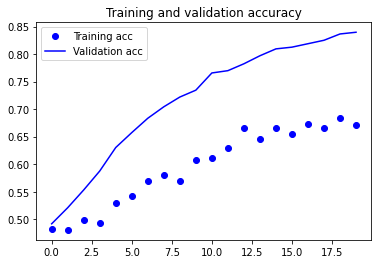

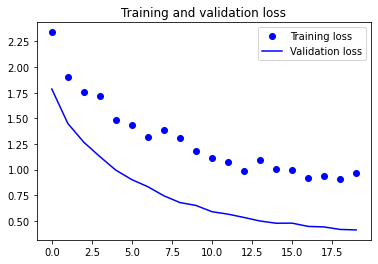

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fine tuning last several layers.

### The steps for fine-tuning a network are as follow:

1) Add your custom network on top of an already trained base network.

2) Freeze the base network.

3) Train the part you added.

4) Unfreeze some layers in the base network.

5) Jointly train both these layers and the part you added.

ทำไปแล้ว 3 ขั้นตอนเพื่อที่จะหาว่า layers ใดควรที่จะ unfreeze

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(conv_base, to_file='conv_base.png', show_shapes=True)
# from IPython.display import Image
# Image(filename='conv_base.png') 

In [23]:
# set 'multiply_16' and following layers trainable (Unfreeze --> multiply_16 ) ให้เป็น layers ที่ train ชุดข้อมูลใหม่

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_15':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))  

x


In [18]:
from tensorflow.keras import callbacks
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5), #lr ควรเล็กกว่า retrain1
              metrics=['acc'])
#add tensorboard_cb
tensorboard_cb = callbacks.TensorBoard(run_logdir)

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4,
      callbacks = tensorboard_cb)

Epoch 1/20
41/41 [==============================] - 4s 94ms/step - loss: 0.9321 - acc: 0.6829 - val_loss: 0.5810 - val_acc: 0.7927
Epoch 2/20
41/41 [==============================] - 3s 78ms/step - loss: 0.9059 - acc: 0.6875 - val_loss: 0.5588 - val_acc: 0.7979
Epoch 3/20
41/41 [==============================] - 3s 78ms/step - loss: 0.8418 - acc: 0.7141 - val_loss: 0.5382 - val_acc: 0.7979
Epoch 4/20
41/41 [==============================] - 3s 80ms/step - loss: 0.8683 - acc: 0.7034 - val_loss: 0.5188 - val_acc: 0.8062
Epoch 5/20
41/41 [==============================] - 3s 80ms/step - loss: 0.8024 - acc: 0.7049 - val_loss: 0.5084 - val_acc: 0.8073
Epoch 6/20
41/41 [==============================] - 3s 79ms/step - loss: 0.8006 - acc: 0.7295 - val_loss: 0.4747 - val_acc: 0.8167
Epoch 7/20
41/41 [==============================] - 3s 80ms/step - loss: 0.8062 - acc: 0.7111 - val_loss: 0.4728 - val_acc: 0.8240
Epoch 8/20
41/41 [==============================] - 3s 81ms/step - loss: 0.8702 - a

41/41 [==============================] - 3s 83ms/step - loss: 0.7156 - acc: 0.7316 - val_loss: 0.4020 - val_acc: 0.8396
Epoch 17/20
41/41 [==============================] - 3s 79ms/step - loss: 0.6457 - acc: 0.7500 - val_loss: 0.3876 - val_acc: 0.8417
Epoch 18/20
41/41 [==============================] - 3s 79ms/step - loss: 0.7254 - acc: 0.7449 - val_loss: 0.3840 - val_acc: 0.8458
Epoch 19/20
41/41 [==============================] - 3s 80ms/step - loss: 0.7537 - acc: 0.7223 - val_loss: 0.3784 - val_acc: 0.8500
Epoch 20/20
41/41 [==============================] - 3s 82ms/step - loss: 0.7000 - acc: 0.7541 - val_loss: 0.3540 - val_acc: 0.8562


In [19]:
os.makedirs("./models", exist_ok=True)
model.save('./models/cats_and_dogs_small.h5')

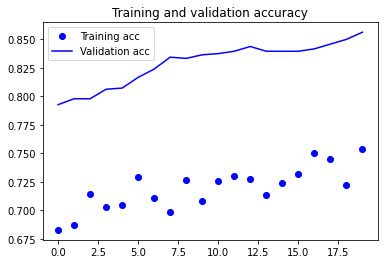

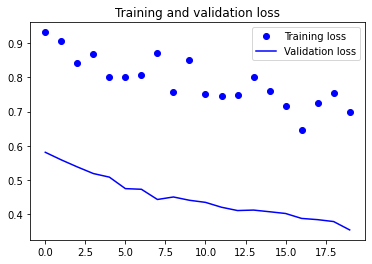

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Test predict

In [21]:
cat_img = cat_images[-1]
dog_img= dog_images[-1]

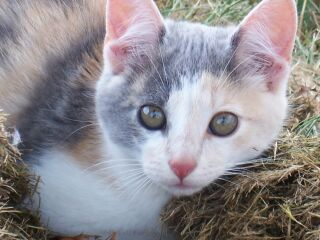

In [22]:
Image(filename=cat_img)

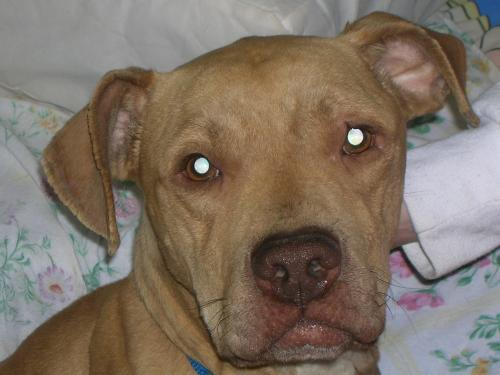

In [23]:
Image(filename=dog_img)

In [24]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])[0][0]
    if result > 0.5:
        animal = "cat"
    else:
        animal = "dog"
        result = 1 - result
    return animal,result

print(predict_image(cat_img))
print(predict_image(dog_img))

('cat', 0.9970092)
('dog', 0.9999761069502711)


## Download the model

In [31]:
model.input_shape

(None, 150, 150, 3)

## Load the model

In [32]:
from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [33]:
from tensorflow.keras.models import load_model
model = load_model("./models/cats_and_dogs_small.h5")

In [26]:
from keras import backend as K
K.clear_session()

In [29]:
from numba import cuda
cuda.select_device(0)
cuda.close()